In [61]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf
import tensorflow_text as tftext

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
use_builtins = True

##### Shape Checker

In [3]:
# Shape Chekcer

class ShapeChecker():
    def __init__(self):
        self.shapes = dict()

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return
        
        if isinstance(names, str):
            names = (names,)
        
        shape = tf.shape(tensor)
        rank = tf.rank(tensor)
        
        if rank != len(names):
            raise ValueError(f"Rank mismatch:\n"
                             f"     found {rank}: {shape.numpy()}\n"
                             f"     expected {len(names)}: {names}"
                             )
        
        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue
            
            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"     found: {new_dim}\n"
                                 f"     expected: {old_dim}\n"
                                 )


In [4]:
import pathlib

path_to_zip = tf.keras.utils.get_file(
    cache_subdir=pathlib.Path.cwd(),
    cache_dir=pathlib.Path.cwd(),
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True
)


path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [5]:
def load_data(path):
    text = path.read_text(encoding='utf-8')

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    inp = [inp for target, inp in pairs]
    target = [target for target, input in pairs]

    return target, inp

In [6]:
target, inp = load_data(path_to_file)
print(inp[-1], '\n', target[-1], sep='')

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [7]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset =  tf.data.Dataset.from_tensor_slices((inp, target)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

2022-07-03 08:28:56.725869: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-03 08:28:56.726086: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-03 08:28:56.726168: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-KRMLHC6): /proc/driver/nvidia/version does not exist
2022-07-03 08:28:56.730014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [9]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5], '\n')
    print(example_target_batch[:5])
    

tf.Tensor(
[b'Hay botellas vac\xc3\xadas en la caja.'
 b'Siempre deber\xc3\xadas golpear la puerta antes de entrar a la habitaci\xc3\xb3n de Tom.'
 b'El perro est\xc3\xa1 jadeando.' b'He comprado una taza de caf\xc3\xa9.'
 b'Felicitaciones por su victoria en el torneo.'], shape=(5,), dtype=string) 

tf.Tensor(
[b'There are some empty bottles in the box.'
 b"You should always knock before entering Tom's room."
 b'The dog is panting.' b"I've bought a cup of coffee."
 b'Let me congratulate you on your victory in the tournament.'], shape=(5,), dtype=string)


### Text Preprocessing

##### Unicode Normalization

In [10]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text)
print(tftext.normalize_utf8(example_text, 'NFKD'))

tf.Tensor(b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?', shape=(), dtype=string)
tf.Tensor(b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?', shape=(), dtype=string)


In [11]:
def tf_lower_and_split_punct(text):
    # Split accented characters
    text = tftext.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)

    # Keep space char, a to z and certain punctuations
    # Replace with blank everything except this regex
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip extra whitespace
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [12]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


##### Text Vectorization

In [14]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)

In [16]:
input_text_processor.adapt(inp) # inp is the list of all spanish examples

# FIrst 10 words from the vocab:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [17]:
input_text_processor.get_vocabulary()[:50]

['',
 '[UNK]',
 '[START]',
 '[END]',
 '.',
 'que',
 'de',
 'el',
 'a',
 'no',
 'tom',
 'la',
 '?',
 '¿',
 'en',
 'es',
 'un',
 'se',
 'me',
 ',',
 'esta',
 'por',
 'lo',
 'una',
 'mi',
 'su',
 'los',
 'con',
 'le',
 'ella',
 'te',
 'para',
 'mary',
 'y',
 'las',
 'mas',
 'tu',
 'al',
 'como',
 'yo',
 'este',
 'estoy',
 'muy',
 'eso',
 'tiene',
 'si',
 'del',
 'estaba',
 'quiero',
 'tengo']

In [18]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)

output_text_processor.adapt(target)
output_text_processor.get_vocabulary()[:20]

['',
 '[UNK]',
 '[START]',
 '[END]',
 '.',
 'the',
 'i',
 'to',
 'you',
 'tom',
 'a',
 '?',
 'is',
 'he',
 'in',
 'of',
 'that',
 'it',
 'was',
 ',']

In [34]:
print(example_input_batch)
example_tokens = input_text_processor(example_input_batch)
# the number of example sentences and the length of each sentence
# extra lengths are padded with 0s
example_tokens[:4, :15]

tf.Tensor(
[b'Hay botellas vac\xc3\xadas en la caja.'
 b'Siempre deber\xc3\xadas golpear la puerta antes de entrar a la habitaci\xc3\xb3n de Tom.'
 b'El perro est\xc3\xa1 jadeando.' b'He comprado una taza de caf\xc3\xa9.'
 b'Felicitaciones por su victoria en el torneo.'
 b'No me gusta salir cuando est\xc3\xa1 oscuro.'
 b'Se mont\xc3\xb3 en su coche.'
 b'O sea, que nuestros esfuerzos fueron para nada.'
 b'Son demasiado peligrosos.' b'Hagamos el trabajo.'
 b'Cree el ladr\xc3\xb3n que todos son de su condici\xc3\xb3n.'
 b'Partir una tarta en partes iguales es bastante complicado.'
 b'Conseguir\xc3\xa9 la direcci\xc3\xb3n de Tom.'
 b'Esta m\xc3\xbasica es de los cuarentas.'
 b'Los aspectos t\xc3\xadpicos de una cultura ajena cambian por los aspectos t\xc3\xadpicos de la cultura local de los traductores.'
 b'Tom sabe demasiado.'
 b'Un per\xc3\xadodo prolongado de tiempo lluvioso es perjudicial para las plantas.'
 b'Son muy valientes.'
 b'Le escribo para expresarle mi insatisfacci\xc3\xb3n.'

<tf.Tensor: shape=(4, 15), dtype=int64, numpy=
array([[   2,   59, 2911, 4316,   14,   11,  443,    4,    3,    0,    0,
           0,    0,    0,    0],
       [   2,  100,  175, 4457,   11,  179,  130,    6,  585,    8,   11,
         173,    6,   10,    4],
       [   2,    7,  144,   20,    1,    4,    3,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   2,   74,  910,   23,  736,    6,  240,    4,    3,    0,    0,
           0,    0,    0,    0]])>

In [39]:
# convert from tokens back to IDs
input_vocab = np.array(input_text_processor.get_vocabulary())
print(example_tokens[0])
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

tf.Tensor(
[   2   59 2911 4316   14   11  443    4    3    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(22,), dtype=int64)


'[START] hay botellas vacias en la caja . [END]             '

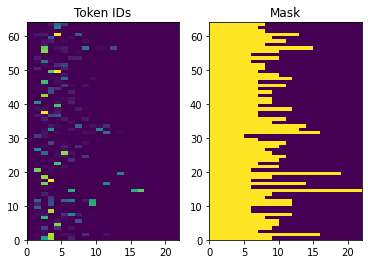

In [41]:
# Visualizing a map and  a mask.
# y axis represents the different strings,
# x axis represents the word in the strings
# the activation of a cell represents the magnitude of the token

plt.subplot(1,2,1)
plt.pcolormesh(example_tokens)
plt.title("Token IDs")

plt.subplot(1,2,2)
plt.pcolormesh(example_tokens!=0)
plt.title("Mask")

plt.show()

### The encoder/decoder model

#### Encoder

In [42]:
# Model constants

embedding_dim = 256
units = 1024

In [43]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding1 = tf.keras.layers.Embedding(
            self.input_vocab_size,
            embedding_dim
        )

        # The GRU layer proceses these embedding vectors as sequences
        self.gru1 = tf.keras.layers.GRU(
            self.enc_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        )

    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))

        vectors = self.embedding1(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))

        # The GRU processes the embedding sequence
        # Output Shape: (batch, s, enc_units)
        # State shape: (batch, enc_units)
        output, state = self.gru1(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))

        return output, state

In [44]:
example_tokens = input_text_processor(example_input_batch)

# Initialize the encoder
encoder = Encoder(
    input_text_processor.vocabulary_size(),
    embedding_dim,
    units
)

# Get encoder output and state by passing the example through the encoder
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens shape (batch, s): {example_tokens.shape}')
print(f'Encoder output shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state shape (batch, units): {example_enc_state.shape}')

Input batch shape (batch): (64,)
Input batch tokens shape (batch, s): (64, 22)
Encoder output shape (batch, s, units): (64, 22, 1024)
Encoder state shape (batch, units): (64, 1024)


#### The attention head

In [54]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))

        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attention_units'))

        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attention_units'))

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs=[w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores=True
        )

        shape_checker(context_vector, ('batch', 's', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))

        return context_vector, attention_weights

In [55]:
attention_layer_test = BahdanauAttention(units)

In [58]:
(example_tokens != 0).shape

TensorShape([64, 22])

In [60]:
example_attention_query = tf.random.normal(shape=[len(example_tokens), 22, 10])

context_vector, attention_weights = attention_layer_test(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0)
)

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 22, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 22, 22)


Text(0.5, 1.0, 'Mask')

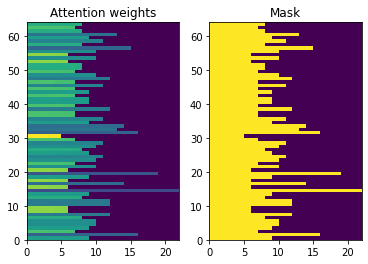

In [52]:
# THe attention weights should sum to 1 for each sequence
plt.subplot(1,2,1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title("Attention weights")

plt.subplot(1,2,2)
plt.pcolormesh(example_tokens!=0)
plt.title("Mask")

In [53]:
attention_weights.shape

TensorShape([64, 22, 22])

#### The decoder

In [65]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        self.embedding1 = tf.keras.layers.Embedding(
            self.output_vocab_size,
            embedding_dim
        )

        self.gru1 = tf.keras.layers.GRU(
            self.dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        )

        self.attention1 = BahdanauAttention(self.dec_units)

        self.Wc = tf.keras.layers.Dense(
            dec_units,
            activation=tf.math.tanh,
            use_bias=False
        )

        self.fc = tf.keras.layers.Dense(self.output_vocab_size)


    class DecoderInput(typing.NamedTuple):
        new_tokens: Any
        enc_output: Any
        mask: Any
    
    class DecoderOutput(typing.NamedTuple):
        logits: Any
        attention_weights: Any

    def call(self,
            inputs: DecoderInput,
            state=None) -> Tuple[DecoderOutput, tf.Tensor]:
        shape_checker = ShapeChecker()
        shape_checker(inputs.new_tokens, ('batch', 't'))
        shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
        shape_checker(inputs.mask, ('batch', 's'))

        if state is not None:
            shape_checker(state, ('batch', 'dec_units'))

        # Lookup the embeddings
        vectors = self.embedding1(inputs.new_tokens)
        shape_checker(vectors, ('batch', 't', 'embedding_dim'))

        # Process one step with the RNN
        rnn_output, state = self.gru1(vectors, initial_state=state)

        shape_checker(rnn_output, ('batch', 't', 'dec_units'))
        shape_checker(state, ('batch', 'dec_units'))

        # Use the RNN output as the query for the attention over the encoder
        # output

        context_vector, attention_weights = self.attention1(
            query=rnn_output,
            value=inputs.enc_output,
            mask=inputs.mask
        )
        
        shape_checker(context_vector, ('batch', 't', 'dec_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))
        
        # Join the context vector and rnn_output
        context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)
        
        attention_vector = self.Wc(context_and_rnn_output)
        shape_checker(attention_vector, ('batch', 't', 'dec_units'))

        logits = self.fc(attention_vector)
        shape_checker(logits, ('batch', 't', 'output_vocab_size'))

        return DecoderOutput(logits, attention_weights), state


In [66]:
decoder = Decoder(
    output_text_processor.vocabulary_size(),
    embedding_dim,
    units
)